### Import Libraries

In [165]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

### Read Data & Assign Accordingly

In [151]:
df = pd.read_csv('data/final_training_data.csv')

In [152]:
clf_target = 'isprofit' # classification model target
reg_target = 'profitability_ratio' # regression model target
des_features = ['budget', 'budget_norm', 'genre', 'popularity', 'popularity_norm', 'rating', 'runtime',
                'runtime_norm', 'score', 'score_norm', 'votes', 'votes_norm', 'year'] # descriptive features

In [153]:
X = df[des_features] # training data is the same for classification model and regression model
y1 = df[clf_target] # y1 corresponds to binary label outcome that will be used in classification
y2 = df[reg_target] # y2 corresponds to continuous outcome that will be used in regression

X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=17)
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=17)

X_train = X_train.reset_index(drop=True)
y1_train = pd.DataFrame(y1_train).reset_index(drop=True)
y2_train = pd.DataFrame(y2_train).reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y1_test = pd.DataFrame(y1_test).reset_index(drop=True)
y2_test = pd.DataFrame(y2_test).reset_index(drop=True)

### Helper Functions

In [156]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            pass
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm

In [157]:
def run_kfold_model(X,y,X_test,y_test,model,fold_indexes,folds=[1,2,3],model_name='Unknown'):
    results = {}
    for fold in folds:
        print('='*5+' '+model_name+' - fold '+str(fold)+' '+'='*5)
        x_train = X.loc[list(fold_indexes[fold]['train'])]
        x_valid = X.loc[list(fold_indexes[fold]['valid'])]
        y_train = y.loc[list(fold_indexes[fold]['train'])]
        y_valid = y.loc[list(fold_indexes[fold]['valid'])]
        print('fitting model...')
        start_time = time.time()
        model.fit(x_train, np.ravel(y_train))
        ex_time = (time.time() - start_time)
        print('model fit!')
        results[fold] = {}
        results[fold]['model'] = model
        results[fold]['preds'] = {
            'train_y_pred': model.predict(x_train),
            'train_y_prob': model.predict_proba(x_train)[:,0],
            'valid_y_pred': model.predict(x_valid),
            'valid_y_prob': model.predict_proba(x_valid)[:,0],
            'test_y_pred': model.predict(X_test),
            'test_y_prob': model.predict_proba(X_test)[:,0],
        }
        results[fold]['execution_time'] = ex_time
        # pprint.pprint(results[fold])
    return results

In [200]:
# This is where we create our folds
kf = KFold(n_splits=3, random_state=17, shuffle=True)
kf.get_n_splits(X_train)
fold_indexes = {}
i = 1
for train_index, valid_index in kf.split(X_train):
    fold_indexes[i]={}
    fold_indexes[i]['train']=train_index
    fold_indexes[i]['valid']=valid_index
    i+=1
    
y1_valid = np.ravel(y1_train.loc[list(fold_indexes[1]['valid'])+list(fold_indexes[2]['valid'])+list(fold_indexes[3]['valid'])])
y1_test = np.ravel(y1_test)

# ========= YOU CAN RUN ABOVE CODE UNTIL THIS POINT ========== 

## Classification Models

### Gradient Boosting Classifier

In [201]:
gb = GradientBoostingClassifier(n_estimators=100)
gb_results = run_kfold_model(X_train,y1_train,X_test,y1_test,gb,fold_indexes,model_name='GB Classification')

===== GB Classification - fold 1 =====
fitting model...
model fit!
===== GB Classification - fold 2 =====
fitting model...
model fit!
===== GB Classification - fold 3 =====
fitting model...
model fit!


#### Confusion Matrix (Validation)

In [202]:
valid_pred = list(gb_results[1]['preds']['valid_y_pred'])+\
             list(gb_results[2]['preds']['valid_y_pred'])+\
             list(gb_results[3]['preds']['valid_y_pred'])

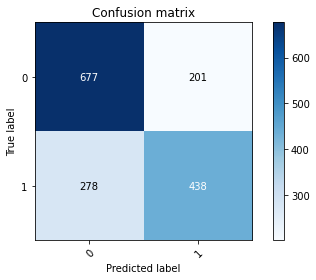

In [205]:
cm = plot_confusion_matrix(y1_valid,valid_pred,classes=[0,1],title='Confusion matrix')
plt.show()

In [206]:
accuracy = (cm[0,0] + cm[1,1]) / cm.sum() # Overall, how often is the classifier correct?
print('Accuracy: {}'.format(round(accuracy,2)))

Accuracy: 0.7


#### Confusion Matrix (Test)

In [207]:
threshold = 0.5
test_probs = gb_results[1]['preds']['test_y_prob']+\
             gb_results[2]['preds']['test_y_prob']+\
             gb_results[3]['preds']['test_y_prob']
test_probs /= 3
test_pred = (test_probs>=threshold).astype(int)

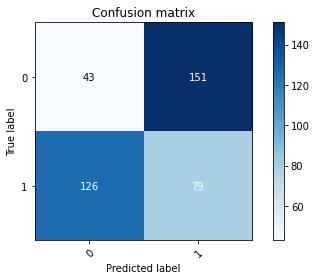

In [208]:
cm = plot_confusion_matrix(y1_test,test_pred,classes=[0,1],title='Confusion matrix')
plt.show()

In [209]:
accuracy = (cm[0,0] + cm[1,1]) / cm.sum() # Overall, how often is the classifier correct?
print('Accuracy: {}'.format(round(accuracy,2)))

Accuracy: 0.31
